In [1]:
from spectral import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.constants as constants
import img
import pandas as pd
from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook
from itertools import islice

def load_flux(fluxname):

    with open(fluxname, 'r') as file:
        data = file.readlines()
        #print(data)
        size = len(data)
        #print(size)
        flux = np.zeros(size)
        wavelengths = np.zeros(size)
        for i in range(size):
            flux[i]=(float(data[i].strip().split(" ,")[1]))
            wavelengths[i]=(float(data[i].strip().split(",")[0]))

    return flux,wavelengths



def load_hdr(filename):
    img = envi.open(filename)
    datafile = img.open_memmap(writeable = False)
    
    return datafile


def load_rdn(filename):
    data = np.load(filename)
    return data


def get_metadata(filename):
    img = envi.open(filename)
    img_data = img.open_memmap(writeable = False)
    metadata = envi.read_envi_header(filename)
    metadata_df = pd.DataFrame.from_dict(metadata, orient='index', columns=['Value'])
    band_names = metadata_df.loc['band names', 'Value']
    bandnames = band_names
    reshape_array = img_data.reshape(-1, img_data.shape[-1])
    df = pd.DataFrame(reshape_array)
    df.columns = band_names
    return df


def get_phase_angle(datafile):
    phase_angle = np.empty(datafile.shape[:-1])
    
    for i in range(len(datafile)):
        for j in range(len(datafile[i])):
            for k in  range(len(datafile[i,j])):
                phase_angle[i,j] = datafile[i,j,4]
    phase_angle = phase_angle.reshape((phase_angle.shape[0], phase_angle.shape[1], 1))
    
    return phase_angle

def get_i(datafile):
    angle_i = np.empty(datafile.shape[:-1])
    
    for i in range(len(datafile)):
        for j in range(len(datafile[i])):
            for k in  range(len(datafile[i,j])):
                angle_i[i,j] = datafile[i,j,1]
    angle_i = angle_i.reshape((angle_i.shape[0], angle_i.shape[1], 1))
    
    return angle_i

def get_e(datafile):
    angle_e = np.empty(datafile.shape[:-1])
    
    for i in range(len(datafile)):
        for j in range(len(datafile[i])):
            for k in  range(len(datafile[i,j])):
                angle_e[i,j] = datafile[i,j,3]
    angle_e = angle_e.reshape((angle_e.shape[0], angle_e.shape[1], 1))
    
    return angle_e

def get_Lsat(datafile):
    L_sat = np.empty(datafile.shape[:-1])
    
    for i in range(len(datafile)):
        for j in range(len(datafile[i])):
            for k in  range(len(datafile[i,j])):
                L_sat[i,j] = datafile[i,j,6]
    L_sat = L_sat.reshape((L_sat.shape[0], L_sat.shape[1], 1))
    
    return L_sat

def get_Lsun(datafile):
    L_sun = np.empty(datafile.shape[:-1])
    
    for i in range(len(datafile)):
        for j in range(len(datafile[i])):
            for k in  range(len(datafile[i,j])):
                L_sun[i,j] = datafile[i,j,6]
    L_sun = L_sun.reshape((L_sun.shape[0], L_sun.shape[1], 1))
    
    return L_sun


def flux_correction(data, flux, band):
    corrected_data = np.zeros((data.shape[0],data.shape[1], 1))
    for i in tqdm(range(len(data))):
        for j in range(len(data[i])):
            corrected_data[i,j,0] = (data[i,j,band]/flux[band]) * np.pi 
    corrected_data = corrected_data.reshape(1,-1)
    corrected_data = np.squeeze(corrected_data)  
    return corrected_data


def splot_binned_data_wphase(binned_angle,binned_reflectance, band):
    plt.scatter(binned_angle,binned_reflectance,marker='s', s=6)
    plt.xlabel('Phase angle(binned and averaged)')
    plt.ylabel('Reflectance(Averaged/binned)')
    plt.title(f'Spectrum for {band}th band') 
    
def binning(binned_matrix,i_data,e_data, phaseangle_data, corr_data):
    
    i_data = i_data.reshape(1,-1)
    i_data = np.squeeze(i_data)
    e_data = e_data.reshape(1,-1)
    e_data = np.squeeze(e_data)
    phaseangle_data = phaseangle_data.reshape(1,-1)
    phaseangle_data = np.squeeze(phaseangle_data)
    
  # Last dimension stores sum of radiance and count of data points

    # Round off the angles to the nearest integer and ensure they fall within the range [0, 120]
    phase_angles = np.round(phaseangle_data).astype(int)
    incidence_angles = np.round(i_data).astype(int)
    emission_angles = np.round(e_data).astype(int)

    # Iterate through each data point
    for phase_angle, incidence_angle, emission_angle, radiance in zip(phase_angles, incidence_angles, emission_angles, corr_data):
        # Update the corresponding bin in the binned_matrix
        binned_matrix[phase_angle, incidence_angle, emission_angle, 0] = phase_angle
        binned_matrix[phase_angle, incidence_angle, emission_angle, 1] = incidence_angle
        binned_matrix[phase_angle, incidence_angle, emission_angle, 2] = emission_angle
        binned_matrix[phase_angle, incidence_angle, emission_angle, 3] += radiance
        binned_matrix[phase_angle, incidence_angle, emission_angle, 4] += 1
        
    return binned_matrix

In [2]:
num_bins = 121 

    # Initialize an empty array to store binned data
binned_matrix = np.zeros((num_bins, num_bins, num_bins, 5))

In [3]:
fluxdatafile = 'Data/m3_solarflux.txt'
imgdatafile = 'Data\OBS DATA\m3g20081129t171431_v03_obs.hdr'          # 11
rdndatafile = 'Data\RDN data\corr_i_m3g20081129t171431_v03_rdn.npy'
band = 50
binsize = 100
flux, wavelengths = load_flux(fluxdatafile)
img_data = load_hdr(imgdatafile)
rdn_data = load_rdn(rdndatafile)
phaseangle_data = get_phase_angle(img_data)
i_data = get_i(img_data)
e_data = get_e(img_data)
L_sat = get_Lsat(img_data)
L_sun = get_Lsun(img_data)


In [8]:
flux[0]

2022.662109

In [5]:
wavelengths

array([ 460.98999 ,  500.920013,  540.840027,  580.765015,  620.689941,
        660.609985,  700.537537,  730.47998 ,  750.440002,  770.400024,
        790.36499 ,  810.330017,  830.290039,  850.25    ,  870.209961,
        890.174988,  910.140015,  930.099976,  950.059998,  970.02002 ,
        989.97998 , 1009.950012, 1029.910034, 1049.869995, 1069.829956,
       1089.790039, 1109.76001 , 1129.719971, 1149.679932, 1169.640015,
       1189.599976, 1209.570068, 1229.530029, 1249.48999 , 1269.449951,
       1289.410034, 1309.375   , 1329.339966, 1349.300049, 1369.26001 ,
       1389.219971, 1409.185059, 1429.150024, 1449.109985, 1469.070068,
       1489.030029, 1508.994995, 1528.959961, 1548.920044, 1578.859985,
       1618.787598, 1658.710083, 1698.630005, 1738.560059, 1778.47998 ,
       1818.405029, 1858.330078, 1898.25    , 1938.179932, 1978.099976,
       2018.022461, 2057.949951, 2097.869873, 2137.797363, 2177.719971,
       2217.642578, 2257.570068, 2297.48999 , 2337.414795, 2377.

In [4]:
wavelengths[9]

770.400024

In [10]:
get_metadata(imgdatafile)

,To-Sun Azimuth (deg),To-Sun Zenith (deg),To-M3 Azimuth (deg),To-M3 Zenith (deg),Phase (deg),To-Sun Path Length (au-0.983748796177),To-M3 Path Length (m),Facet Slope (deg),Facet Aspect (deg),Facet Cos(i) (unitless)
0,327.868561,31.682243,93.887314,12.124657,39.903957,-1.139751e-07,107386.765625,22.572660,172.967422,0.603216
1,327.859131,31.684753,93.918655,12.042387,39.850403,-1.136590e-07,107364.531250,22.673283,172.347290,0.600931
2,327.849701,31.687263,93.950317,11.960123,39.796890,-1.133403e-07,107342.992188,22.814390,171.867645,0.598314
3,327.840302,31.689770,93.982292,11.877869,39.743423,-1.130174e-07,107322.492188,23.037460,171.672089,0.594998
4,327.830902,31.692278,94.014603,11.795617,39.690006,-1.126940e-07,107302.265625,23.260284,171.484390,0.591684
...,...,...,...,...,...,...,...,...,...,...
76299,326.368073,33.590370,270.374084,12.538933,28.318735,1.043188e-07,108132.296875,12.804403,295.335327,0.917363
76300,326.360016,33.593285,270.403809,12.620965,28.292582,1.043807e-07,108116.234375,12.917583,295.110779,0.917649
76301,326.351685,33.596275,270.433167,12.703132,28.266575,1.045519e-07,108118.914062,13.010563,294.820312,0.917755
76302,326.343384,33.599262,270.462280,12.785294,28.240715,1.047177e-07,108120.843750,12.957898,294.515900,0.917147


In [6]:
num_bins = 121 

    # Initialize an empty array to store binned data
binned_matrix = np.zeros((num_bins, num_bins, num_bins, 5))
import os
import glob

# Path to the folders containing the files
obsdata = 'Data\OBS DATA'
rdndata = 'Data\RDN data'

# Get the list of files in each folder
obs_files_ = os.listdir(obsdata)
rdn_files = os.listdir(rdndata)
obs_files = [file for file in obs_files_ if file.endswith(".hdr")]




# Iterate over the files in both folders simultaneously
for file1, file2 in tqdm(zip(obs_files, rdn_files), total=len(obs_files)):
    # Construct the full paths to the files
    obs_path = os.path.join(obsdata, file1)
    rdn_path = os.path.join(rdndata, file2)

    img_datafile = obs_path
    rdn_datafile = rdn_path
    fluxdatafile = 'Data/m3_solarflux.txt'
    imgdatafile = obs_path
    rdndatafile = rdn_path
    band = 9
    flux, wavelengths = load_flux(fluxdatafile)
    img_data = load_hdr(imgdatafile)
    rdn_data = load_rdn(rdndatafile)
    phaseangle_data = get_phase_angle(img_data)
    i_data = get_i(img_data)
    e_data = get_e(img_data)
    corr_data = flux_correction(rdn_data, flux, band)
    
    binned_matrix = binning(binned_matrix, i_data, e_data, phaseangle_data, corr_data)
    

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6203 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/6198 [00:00<?, ?it/s]

  0%|          | 0/6129 [00:00<?, ?it/s]

  0%|          | 0/11936 [00:00<?, ?it/s]

  0%|          | 0/11935 [00:00<?, ?it/s]

  0%|          | 0/25201 [00:00<?, ?it/s]

  0%|          | 0/27048 [00:00<?, ?it/s]

  0%|          | 0/30250 [00:00<?, ?it/s]

  0%|          | 0/27549 [00:00<?, ?it/s]

  0%|          | 0/21748 [00:00<?, ?it/s]

  0%|          | 0/15446 [00:00<?, ?it/s]

  0%|          | 0/3685 [00:00<?, ?it/s]

  0%|          | 0/29792 [00:00<?, ?it/s]

  0%|          | 0/30156 [00:00<?, ?it/s]

  0%|          | 0/14707 [00:00<?, ?it/s]

  0%|          | 0/15512 [00:00<?, ?it/s]

  0%|          | 0/30250 [00:00<?, ?it/s]

  0%|          | 0/30648 [00:00<?, ?it/s]

  0%|          | 0/30250 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Reflectance spectra')

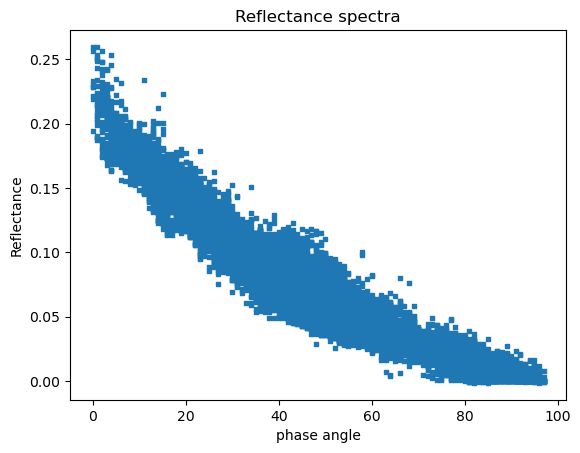

In [7]:
bined_matrix = np.copy(binned_matrix)
for i in range(num_bins):
    for j in range(num_bins):
        for k in range(num_bins):
            # Check if the bin has any data points
            if bined_matrix[i, j, k, 1] != 0:
                # Calculate the average radiance
                bined_matrix[i, j, k, 3] /= bined_matrix[i, j, k, 4]


nonzero_indices = np.nonzero((bined_matrix[:, :, :, 3] != 0) | (bined_matrix[:, :, :, 4] != 0))

#Create a new matrix to store only the non-zero elements
bin_matrix = bined_matrix[nonzero_indices]
plt.scatter(bin_matrix[:,0], bin_matrix[:,3], marker='s', s=5)
plt.xlabel('phase angle')
plt.ylabel('Reflectance')
plt.title('Reflectance spectra')


In [8]:
np.savetxt('10thband.txt', bin_matrix)

In [14]:
np.where(bin_matrix[:,3]>1)

(array([], dtype=int64),)